# TP 3

## Punto 3

### Modelo 1

Importo las librerias que utilizare en en desarrollo del tp.

In [1]:
import warnings 
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
import numpy as np
import math
from tqdm import tqdm
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
import xgboost as xgb
import category_encoders.utils as util
from category_encoders import TargetEncoder
from sklearn.feature_extraction.text import CountVectorizer

Lectura de archivos

In [2]:
iden = pd.read_csv('train_identity.csv')

In [3]:
trans = pd.read_csv('train_transaction.csv')

Merge de df

In [4]:
joined = trans.merge(iden,how='left')

In [5]:
del(joined['TransactionID'])

Libero RAM

In [6]:
del iden

In [7]:
del trans

Busco el valor limite entre train y validation para hacer el split

In [8]:
limite = np.percentile(joined['TransactionDT'], 80)

Genero el DF de Validation

In [9]:
filtro_validation = joined['TransactionDT'] > limite

In [10]:
validation = joined[filtro_validation]

In [11]:
label_validation = validation[['isFraud']]

In [12]:
del(validation['isFraud'])

Genero el DF de train

In [13]:
filtro_train = joined['TransactionDT']<= limite

In [14]:
train = joined[filtro_train]

In [15]:
label_train = train[['isFraud']]

In [16]:
del(train['isFraud'])

Libero RAM


In [17]:
del joined

### Encodings

Creo un diccionario para almancenar los encodings.

In [18]:
dict_encoding = {}

Creo funciones para aplicar los encodings.

In [19]:
def countVect(df,columna,dic):
    if columna not in dic:
        dic[columna] = CountVectorizer(max_features =10)
        col_encoded = dic[columna].fit_transform(df[columna].fillna('desconocido')).astype(int).toarray()
    else:
        col_encoded = dic[columna].transform(df[columna].fillna('desconocido')).astype(int).toarray()
    col_encoded = pd.DataFrame(col_encoded).add_prefix(columna+ '_enconded_').fillna(0)
    del(df[columna])
    df_nuevo = pd.concat([df.reset_index(drop=True),col_encoded], axis=1)
    return df_nuevo

In [20]:
def one_hot_encode(df, columna, dict_encoding):
    if columna not in dict_encoding:
        dict_encoding[columna] = OneHotEncoder(handle_unknown='ignore')
        dict_encoding[columna].fit_transform(df[[columna]].astype(str)).astype(int)
    col_encoded = (dict_encoding[columna].transform(df[[columna]].astype(str)).astype(int))
    col_encoded = pd.DataFrame(col_encoded.todense()).add_prefix(columna + '_').fillna(0)
    del(df[columna])
    df_nuevo = pd.concat([df.reset_index(drop=True), col_encoded], axis=1)
    return df_nuevo

In [21]:
def mean_encoding_train(df,columna,label, dict_encoding):
    if columna not in dict_encoding:
        dict_encoding[columna] = TargetEncoder(handle_unknown='ignore')
    df[columna] = dict_encoding[columna].fit_transform(df[[columna]], label)
    df[columna].fillna(0,inplace=True)
    return df

In [22]:
def mean_encoding_val_test(df,columna, dict_encoding):
    df[columna] = dict_encoding[columna].transform(df[[columna]])
    df[columna].fillna(0,inplace=True)
    return df

In [23]:
def label_ec(df):
    for column in df.columns:
        if df[column].dtypes==object:
            dict_encoding[column] = OrdinalEncoder(handle_unknown='ignore')
            df[column] = dict_encoding[column].fit_transform(df[column].astype(str).values.reshape(-1, 1))
    if df[column].dtype==object:
        df[column] = dict_encoding[column].transform(df[column].astype(str).values.reshape(-1, 1))
    df.fillna(-1,inplace=True)
    return(df)

Defino los features que les aplicare los encodings: oneHot, mean o CountVectorizer

In [24]:
countV = ['id_30','id_31','DeviceInfo']

In [25]:
mean = ['addr2','DeviceType']

In [26]:
oneHot = ['P_emaildomain','card4','ProductCD','id_38','id_35','id_34']

### Modelo

In [27]:
xboost = xgb.XGBClassifier(random_state=0)

In [28]:
#xboost.get_xgb_params()

### Train

Realizo los encodings.

In [29]:
del(train['TransactionAmt'])

In [30]:
del(train['TransactionDT'])

In [31]:
for i in countV:
    train=countVect(train,i,dict_encoding)

In [32]:
for i in oneHot:
    train = one_hot_encode(train,i,dict_encoding)

In [33]:
for i in mean:
    train = mean_encoding_train(train,i,label_train,dict_encoding)

In [34]:
train = label_ec(train)

Entreno el modelo

In [35]:
xboost.fit(train,label_train)

[15:33:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Verifico haber encodeado los 4 features obligatorios.

In [36]:
dict_encoding['DeviceInfo']

CountVectorizer(max_features=10)

In [37]:
dict_encoding['DeviceType']

TargetEncoder(cols=['DeviceType'], handle_unknown='ignore')

In [38]:
dict_encoding['id_31']

CountVectorizer(max_features=10)

In [39]:
dict_encoding['id_33']

OrdinalEncoder(handle_unknown='ignore')

### Validation


Realizo los encodings.

In [40]:
del(validation['TransactionAmt'])

In [41]:
del(validation['TransactionDT'])

In [42]:
for i in countV:
    validation=countVect(validation,i,dict_encoding)

In [43]:
for i in oneHot:
    validation = one_hot_encode(validation,i,dict_encoding)

In [44]:
for i in mean:
    validation = mean_encoding_val_test(validation,i,dict_encoding)

In [45]:
validation = label_ec(validation)

Se muestra el classification report.

In [46]:
print(classification_report(label_validation, xboost.predict(validation)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    114044
           1       0.73      0.37      0.49      4064

    accuracy                           0.97    118108
   macro avg       0.86      0.68      0.74    118108
weighted avg       0.97      0.97      0.97    118108



Calculo el ***roc auc*** del validation con el modelo manual.

In [47]:
roc_auc_score(label_validation, xboost.predict_proba(validation)[:,1])

0.892838762138912

### Hiperparametros

Realizo la busqueda de hiperparametros utilizando RandomizedSearchCV de *Sklearn*.

In [48]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform
# clf = xgb.XGBClassifier(objective='binary:logistic',random_state=0)
# distributions = dict(n_estimators = [60,80,90,100,120,130,140,150,160,170,180,190,200],
#                      max_depth = [3,4,5,6,7,8,9,10,11,12,13,14,15],
#                      subsample =[0.6,0.7,0.8,0.9,1],
#                      learning_rate=[0,0.05,0.1,0.15,0.20,0.25,0.3],
#                      colsample_bytree=[0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0,98,0.99,1],
#                      gamma =[0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0,98,0.99,1])
                     
# rs = RandomizedSearchCV(clf, distributions, scoring='roc_auc',n_jobs=1, verbose=100, cv=3,n_iter=4, random_state=0)
# search = rs.fit(train, label_train)
# search.best_params_

Guardo el modelo de hiperparametros.

In [49]:
# import pickle
# with open('model_probando', 'wb') as model_backup_file:
#     pickle.dump(search, model_backup_file)

Cargo el modelo con hiperparametros.

In [50]:
import pickle
with open('model_probando', 'rb') as file:
     search = pickle.load(file)

Se muestran los mejores parametros seleccionados por el RandomizedSearch de *Sklearn*.

In [51]:
search.best_params_

{'subsample': 0.7,
 'n_estimators': 100,
 'max_depth': 13,
 'learning_rate': 0.2,
 'gamma': 0.85,
 'colsample_bytree': 0.88}

In [52]:
print(classification_report(label_validation, search.predict(validation)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    114044
           1       0.79      0.37      0.50      4064

    accuracy                           0.97    118108
   macro avg       0.88      0.68      0.74    118108
weighted avg       0.97      0.97      0.97    118108



In [53]:
roc_auc_score(label_validation, search.predict_proba(validation)[:,1])

0.8953644818966818

### Respuesta
Para el mejor modelo de ambos, ¿cuál es el score en la competencia? (guardar el
csv con predicciones para entregarlo después)


Dado que el mejor modelo (el que me dio el roc auc mas alto para el validation) es el search, fue el que me dio un roc auc de 0.8953, que resulto el mas alto, lo utilizare para cargarlo a Kaggle. 

###### Leo Test para calcular el predict proba para la competencia

In [54]:
idenTest = pd.read_csv('test_identity.csv')

In [55]:
transTest = pd.read_csv('test_transaction.csv')

Renombro las cols dado que tienen nombre distintos a los df de train y validation.

In [56]:
def renombrar(df):
    for columna in df.columns:
        if columna.startswith('id'):
            ss = columna.split('-')
            df.rename(columns={columna:ss[0]+'_'+ss[1]},inplace=True)
    return (df)
        

In [57]:
idenTest = renombrar(idenTest)

Realizo el merge de los dos df.

In [58]:
test = transTest.merge(idenTest,how='left')

In [59]:
ids = test[['TransactionID']]

In [60]:
del(test['TransactionID'])

Realizo los encodings.

In [61]:
for i in countV:
    test=countVect(test,i,dict_encoding)

In [62]:
for i in oneHot:
    test = one_hot_encode(test,i,dict_encoding)

In [63]:
for i in mean:
    test = mean_encoding_val_test(test,i,dict_encoding)

In [64]:
test = label_ec(test)

In [65]:
del(test['TransactionAmt'])

In [66]:
del(test['TransactionDT'])

Calculo el predict_proba

In [67]:
test['isFraud'] =search.predict_proba(test)[:,1]

In [68]:
test = test[['isFraud']]

In [69]:
join = ids.join(test)

Se visualiza el df que sera subido al Kaggle.

In [70]:
join

,TransactionID,isFraud
0,3663549,0.001260
1,3663550,0.000598
2,3663551,0.002048
3,3663552,0.000313
4,3663553,0.001484
...,...,...
506686,4170235,0.009713
506687,4170236,0.004295
506688,4170237,0.004785
506689,4170238,0.006336


In [71]:
join.to_csv("modelo-xgboost.csv", index = False)

El score obtenido en la competencia fue:
<img src = 'mejor-score.png' alt = "title">

## Adicionales

### Graficar la importancia de features

In [72]:
import shap
shap.initjs()

In [73]:
exp = shap.TreeExplainer(xboost)

In [74]:
shap_v = exp.shap_values(train)

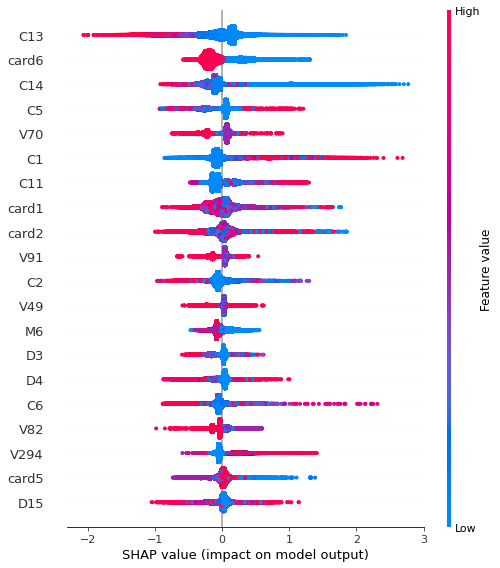

In [75]:
shap.summary_plot (shap_v, features = train, feature_names = train.columns)

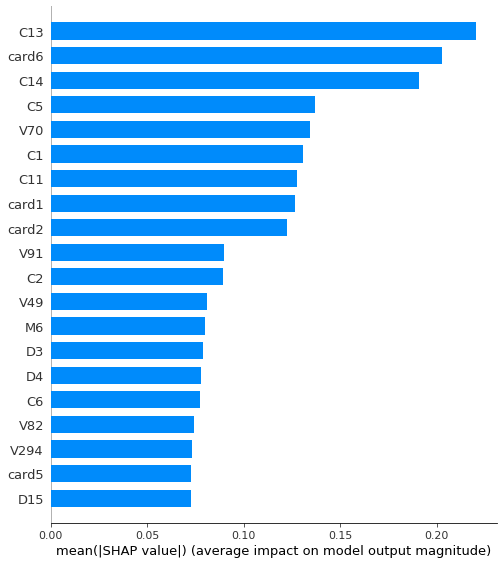

In [76]:
shap.summary_plot(shap_v, features=train, feature_names=train.columns, plot_type='bar')

In [77]:
#explainer = shap.TreeExplainer(search.best_estimator_)

In [78]:
#shap_values = explainer.shap_values(train)

In [79]:
#shap.summary_plot (shap_values, features = train, feature_names = train.columns)

In [80]:
#shap.summary_plot(shap_values, features=train, feature_names=train.columns, plot_type='bar')

### Matriz de confusión

In [81]:
from sklearn.metrics import confusion_matrix

In [85]:
y = label_validation
y_pred = search.predict(validation)

In [86]:
Cm = confusion_matrix(y, y_pred,normalize='true')#, labels=["No fraude","Fraude"])

"\nax.set_title('Confusion Matrix')\nax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business'])\n"

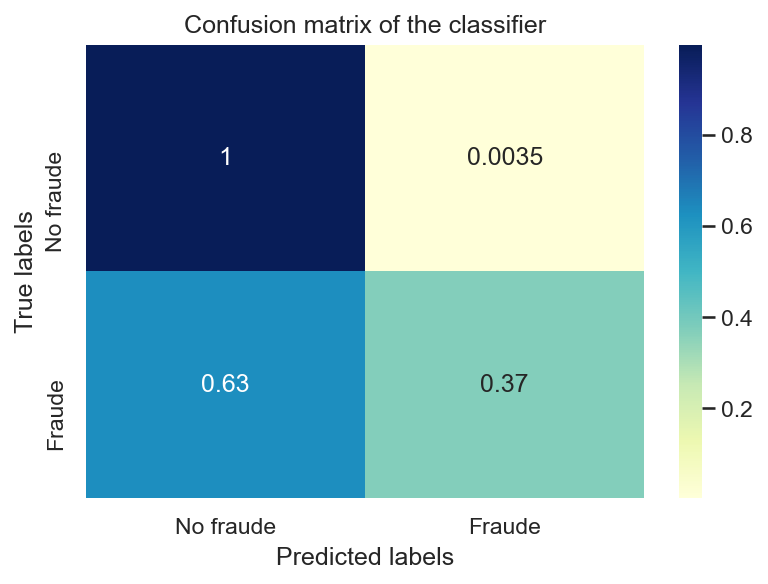

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt     

sns.set(rc={"figure.dpi":150})
ax= plt.subplot()
sns.heatmap(Cm, annot=True, ax = ax,cmap="YlGnBu") #annot=True to annotate cells
plt.title('Confusion matrix of the classifier')
ax.xaxis.set_ticklabels(["No fraude","Fraude"])
ax.yaxis.set_ticklabels(["No fraude","Fraude"])

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.savefig("matriz-confusion-modelo-red.png")
"""
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business'])
"""